For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


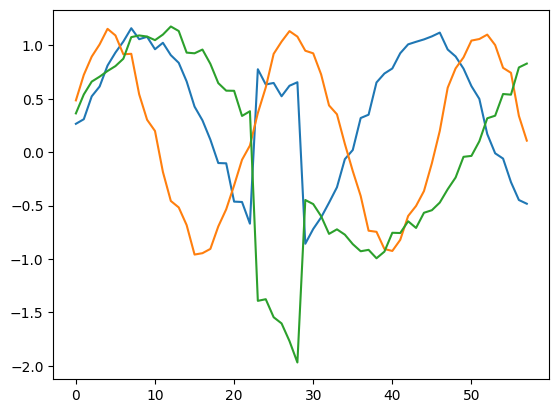

[False False False  True  True]


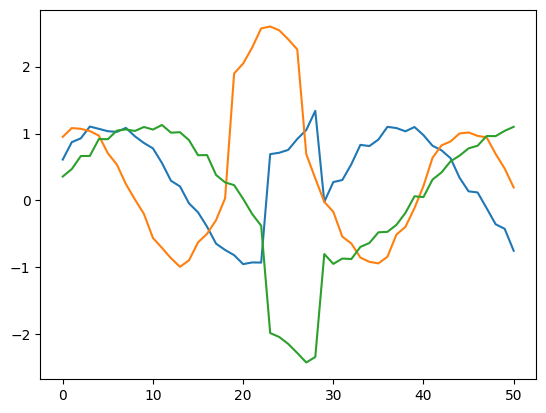

[False False False False False]


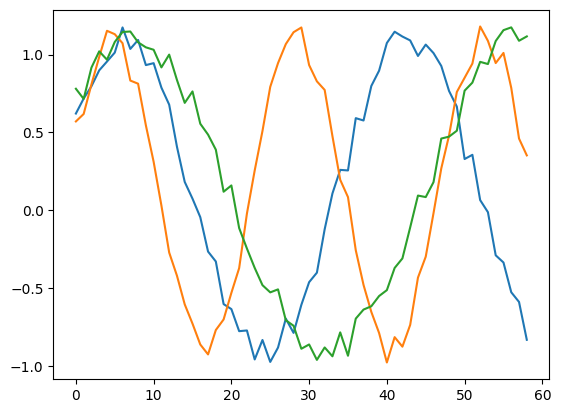

[ True False False False  True]


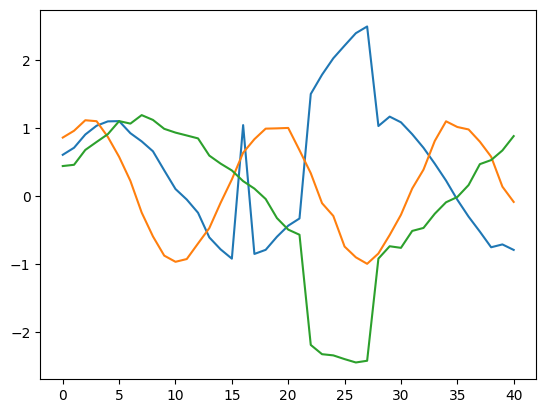

[False  True False False False]


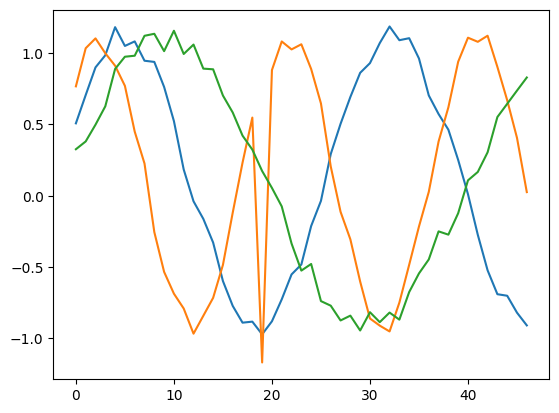

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# ============================================
# CONFIGURATION (Domain-Agnostic)
# ============================================

# Thinngs to be considered: simplified classification without using context

# What we KNOW from the problem statement (ALLOWED):
NUM_SENSORS = 3           # Number of sensor channels
NUM_DEFECT_TYPES = 5      # Number of defect types to detect
HIDDEN_SIZE = 128         # Model capacity
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001

# Generic naming (no domain knowledge about defect characteristics)
DEFECT_NAMES = [f'Defect Type {i}' for i in range(NUM_DEFECT_TYPES)]
SENSOR_NAMES = [f'Sensor {i}' for i in range(NUM_SENSORS)]

# What we DON'T know and must learn:
# - What each defect type looks like (patterns, thresholds)
# - Which sensors are affected by which defects
# - Where in the time series defects occur
# - How to distinguish between defect types


class AttentionLSTM(nn.Module):
    """
    Uses class labels - learns patterns from data
    Provides root cause analysis via attention mechanism
    
    Args:
        input_size: Number of sensors (features)
        hidden_size: LSTM hidden dimension
        num_classes: Number of defect types to detect
    """
    def __init__(self, input_size=NUM_SENSORS, hidden_size=HIDDEN_SIZE, num_classes=NUM_DEFECT_TYPES):
        super().__init__()
        
        self.num_classes = num_classes  # Store for reference
        
        # Bidirectional LSTM encoder
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Per-class attention (learns which timesteps matter for each defect)
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            ) for _ in range(num_classes)
        ])
        
        # Per-class classifiers, for each defect type a context is provided as an input
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
                nn.Sigmoid()
            ) for _ in range(num_classes)
        ])
    
    def forward(self, x, return_attention=False):
        # Encode sequence
        encoder_out, _ = self.lstm(x)  # [batch, seq_len, hidden*2]
        
        predictions = []
        attentions = []
        
        # For each defect independently
        for i in range(len(self.classifiers)):
            # Attention scores [batch, seq_len, 1]
            attn_scores = self.attention_layers[i](encoder_out)  
            # Sums up attention scores to 1 using softmax
            attn_weights = F.softmax(attn_scores, dim=1)
            
            # Create a context out of weights  [batch, hidden*2]
            context = (encoder_out * attn_weights).sum(dim=1)  
            
            # Classify
            pred = self.classifiers[i](context)  # [batch, 1]
            
            predictions.append(pred)
            attentions.append(attn_weights)
        
        predictions = torch.cat(predictions, dim=1)  # [batch, num_classes]
        
        if return_attention:
            attentions = torch.cat(attentions, dim=2)  # [batch, seq_len, num_classes]
            return predictions, attentions
        
        return predictions

def prepare_data(xl, yl):
    """
    Find max sequence length and pad sequences to match it, for batch processing.
    Converting to tensors for optimization purposes.

    Args:
        xl: List of time series arrays [seq_len, num_sensors]
        yl: List of binary label arrays [num_defect_types]
    
    Returns:
        sequences: Padded tensor [N, max_len, num_sensors]
        labels: Tensor [N, num_defect_types]
    """
    max_len = max(len(x) for x in xl)
    N = len(xl)
    
    sequences = torch.zeros(N, max_len, NUM_SENSORS)
    labels = torch.tensor(yl, dtype=torch.float32)
    
    for i, x in enumerate(xl):
        seq_len = len(x)
        sequences[i, :seq_len, :] = torch.tensor(x, dtype=torch.float32)
    
    return sequences, labels

def analyze_root_cause(model, x, class_idx, class_name, min_threshold=0.05):
    """
    Analyze what the model learned for a specific defect type
    Uses ONLY attention weights (no domain knowledge)
    
    Args:
        model: Trained model
        x: Input sequence [seq_len, num_sensors]
        class_idx: Index of defect type
        class_name: Name of defect type (generic)
        min_threshold: Minimum attention threshold to consider (default: 0.05)
    
    Returns:
        Dictionary with root cause analysis (or None if defect not detected)
    """
    model.eval()
    with torch.no_grad():
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        preds, attentions = model(x, return_attention=True)
    
    attention = attentions[0, :, class_idx].numpy()  # [seq_len]
    x_np = x[0].numpy()  # [seq_len, num_sensors]
    
    # Simple threshold - filter out very low attention weights
    important_mask = attention > min_threshold
    important_indices = np.where(important_mask)[0]
    
    if len(important_indices) == 0:
        return None
    
    # Analyze which sensors are most active in important regions
    sensor_importance = np.zeros(NUM_SENSORS)
    for sensor_idx in range(NUM_SENSORS):
        # Compute variance in important vs unimportant regions
        if important_mask.sum() > 0:
            important_vals = x_np[important_mask, sensor_idx]
            unimportant_vals = x_np[~important_mask, sensor_idx]
            
            # Higher variance = more activity = more important
            sensor_importance[sensor_idx] = np.std(important_vals) / (np.std(unimportant_vals) + 1e-6)
    
    # Find contiguous ranges
    ranges = []
    if len(important_indices) > 0:
        start = important_indices[0]
        prev = important_indices[0]
        
        for idx in important_indices[1:]:
            if idx != prev + 1:
                ranges.append((int(start), int(prev)))
                start = idx
            prev = idx
        ranges.append((int(start), int(prev)))
    
    return {
        'defect_type': class_name,
        'confidence': float(preds[0, class_idx]),
        'important_timesteps': important_indices.tolist(),
        'ranges': ranges,
        'sensor_importance': sensor_importance / (sensor_importance.sum() + 1e-6),
        'attention': attention
    }

def visualize_results(model, x, y_true, idx=0, min_threshold=0.05):
    """Visualize classification and root cause with gradient-based attention coloring"""
    model.eval()
    with torch.no_grad():
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        preds, attentions = model(x, return_attention=True)
    
    x_np = x[0].numpy()
    preds_np = preds[0].numpy()
    attentions_np = attentions[0].numpy()
    
    # Generic naming - no domain knowledge about what defects are
    class_names = [f'Defect Type {i}' for i in range(5)]
    sensor_names = [f'Sensor {i}' for i in range(3)]
    true_labels = y_true.numpy() if torch.is_tensor(y_true) else y_true
    pred_labels = (preds_np > 0.5).astype(int)
    
    detected_classes = [i for i, p in enumerate(pred_labels) if p == 1]
    num_detected = len(detected_classes)
    
    # Create figure with variable number of subplots: 3 fixed + num_detected + 1 summary
    num_plots = 4 + num_detected
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 3 * num_plots))
    
    # 1. Classification results
    ax = axes[0]
    x_pos = np.arange(5)
    width = 0.35
    ax.bar(x_pos - width/2, true_labels, width, label='True', alpha=0.8, color='green')
    ax.bar(x_pos + width/2, pred_labels, width, label='Predicted', alpha=0.8, color='blue')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(class_names, rotation=15)
    ax.set_ylabel('Present')
    ax.set_title(f'Sample {idx}: Classification Results', fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for i, (prob, pred) in enumerate(zip(preds_np, pred_labels)):
        color = 'green' if pred == true_labels[i] else 'red'
        ax.text(i, pred + 0.1, f'{prob:.2f}', ha='center', fontweight='bold', color=color)
    
    # 2. Time series
    ax = axes[1]
    seq_len = len(x_np)
    time_axis = np.arange(seq_len)
    for sensor_idx in range(NUM_SENSORS):
        ax.plot(time_axis, x_np[:, sensor_idx], label=SENSOR_NAMES[sensor_idx], alpha=0.8)
    ax.set_title('Time Series', fontweight='bold')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Attention heatmap for detected classes
    ax = axes[2]
    if detected_classes:
        attn_matrix = attentions_np[:, detected_classes].T
        im = ax.imshow(attn_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        ax.set_yticks(range(len(detected_classes)))
        ax.set_yticklabels([DEFECT_NAMES[i] for i in detected_classes])
        ax.set_xlabel('Timestep')
        ax.set_title('Attention Heatmap (Which timesteps matter?)', fontweight='bold')
        plt.colorbar(im, ax=ax, label='Attention Weight')
    else:
        ax.text(0.5, 0.5, 'No defects detected', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Attention Heatmap', fontweight='bold')
    
    # 4-N. Individual attention plots for each detected defect
    seq_len = len(x_np)
    time_axis = np.arange(seq_len)
    base_colors = ['red', 'orange', 'purple', 'brown', 'pink']
    
    for det_idx, class_idx in enumerate(detected_classes):
        ax = axes[3 + det_idx]
        
        # Plot time series
        for sensor_idx in range(NUM_SENSORS):
            ax.plot(time_axis, x_np[:, sensor_idx], label=SENSOR_NAMES[sensor_idx], alpha=0.5, linewidth=1)
        
        attn = attentions_np[:, class_idx]
        base_color = base_colors[det_idx % len(base_colors)]
        
        # Normalize attention for THIS defect only
        max_attn_this_defect = np.max(attn)
        min_attn_this_defect = np.min(attn[attn > min_threshold]) if np.any(attn > min_threshold) else 0
        
        # For each timestep, create a color based on normalized attention weight
        y_min, y_max = ax.get_ylim()
        
        for t in range(len(attn)):
            weight = attn[t]
            
            # Only show if above minimum threshold
            if weight > min_threshold:
                # Normalize weight relative to THIS defect's max (0 to 1 range)
                if max_attn_this_defect > min_threshold:
                    normalized_weight = (weight - min_threshold) / (max_attn_this_defect - min_threshold)
                else:
                    normalized_weight = 0
                
                # Scale alpha by normalized weight (weak -> nearly transparent, strong -> solid)
                alpha = 0.1 + normalized_weight * 0.4  # Range from 0.1 to 0.5
                
                # Create colored region
                ax.axvspan(t - 0.5, t + 0.5, 
                          facecolor=base_color, 
                          alpha=alpha,
                          linewidth=0)
        
        ax.set_title(f'Sample {idx} - Detection #{det_idx + 1}: {DEFECT_NAMES[class_idx]} Attention (max={max_attn_this_defect:.3f})', 
                    fontweight='bold', color=base_color)
        ax.set_ylabel('Value')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-0.5, len(time_axis) - 0.5)
    
    # Last plot: Root cause summary
    ax = axes[-1]
    ax.axis('off')
    
    summary_text = f"ROOT CAUSE ANALYSIS (Sample {idx}):\n" + "="*60 + "\n\n"
    
    if not detected_classes:
        summary_text += "No defects detected - candy is OK!"
    else:
        for class_idx in detected_classes:
            analysis = analyze_root_cause(model, x[0], class_idx, DEFECT_NAMES[class_idx], min_threshold)
            if analysis:
                summary_text += f"• {analysis['defect_type']} (confidence: {analysis['confidence']:.3f})\n"
                summary_text += f"  Critical timesteps: {analysis['ranges']}\n"
                summary_text += f"  Sensor importance: "
                for s_idx, importance in enumerate(analysis['sensor_importance']):
                    summary_text += f"{SENSOR_NAMES[s_idx]}={importance:.2f} "
                summary_text += "\n"
                # Show max attention weight
                max_attn = np.max(analysis['attention'])
                summary_text += f"  Max attention weight: {max_attn:.3f}\n\n"
    
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, 
           fontsize=10, verticalalignment='top', family='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"SAMPLE {idx} ANALYSIS")
    print(f"True labels:      {true_labels}")
    print(f"Predicted labels: {pred_labels}")
    print(f"Predictions:      {preds_np}")
    
    if detected_classes:
        print(f"\nROOT CAUSE:")
        for class_idx in detected_classes:
            analysis = analyze_root_cause(model, x[0], class_idx, DEFECT_NAMES[class_idx], min_threshold)
            if analysis:
                print(f"\n  {analysis['defect_type']}:")
                print(f"    Confidence: {analysis['confidence']:.3f}")
                print(f"    Critical regions: {analysis['ranges']}")
                print(f"    Max attention: {np.max(analysis['attention']):.3f}")
                print(f"    Sensor importance: {dict(zip(SENSOR_NAMES, analysis['sensor_importance']))}")

# Prepare data
print("\n[1/4] Preparing data...")
sequences, labels = prepare_data(xl, yl)
print(f"Total samples: {len(sequences)}")
print(f"Sequence shape: {sequences.shape}")
print(f"Labels shape: {labels.shape}")

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Create model
print("\n[2/4] Creating model...")
model = AttentionLSTM(input_size=NUM_SENSORS, hidden_size=HIDDEN_SIZE, num_classes=NUM_DEFECT_TYPES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# Training
print("\n[3/4] Training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    for i in range(0, len(X_train), BATCH_SIZE):
        batch_x = X_train[i:i+BATCH_SIZE]
        batch_y = y_train[i:i+BATCH_SIZE]
        
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val)
        val_acc = ((val_preds > 0.5) == y_val).float().mean()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {total_loss/len(X_train):.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluation
print("\n[4/4] Evaluating...")
model.eval()
with torch.no_grad():
    test_preds = model(X_test)

test_binary = (test_preds > 0.5).float()
test_acc = (test_binary == y_test).float().mean()

print(f"Overall Accuracy: {test_acc:.4f}")

# Per-class metrics
print("\nPer-Class Performance:")
for i, name in enumerate(DEFECT_NAMES):
    prec = precision_score(y_test[:, i].numpy(), test_binary[:, i].numpy(), zero_division=0)
    rec = recall_score(y_test[:, i].numpy(), test_binary[:, i].numpy(), zero_division=0)
    f1 = 2 * prec * rec / (prec + rec + 1e-6)
    print(f"  {name:15s}: P={prec:.3f}, R={rec:.3f}, F1={f1:.3f}")

# Perfect predictions
perfect = (test_binary == y_test).all(dim=1).sum()
print(f"\nPerfect predictions: {perfect}/{len(y_test)} ({100*perfect/len(y_test):.1f}%)")

# Visualize examples - first occurrence of each defect type
print("VISUALIZATIONS - First Detection of Each Defect Type")


# Find first example where each defect is detected
shown_defects = set()
sample_idx = 0

for i in range(len(X_test)):
    with torch.no_grad():
        preds = model(X_test[i].unsqueeze(0))
    pred_labels = (preds[0] > 0.5).numpy()
    
    # Check which defects are detected in this sample
    detected = [idx for idx, val in enumerate(pred_labels) if val == 1]
    
    # Show if we haven't shown this defect yet
    new_detections = [d for d in detected if d not in shown_defects]
    if new_detections:
        visualize_results(model, X_test[i], y_test[i], idx=i)
        shown_defects.update(detected)
        sample_idx += 1
    
    # Stop when we've shown at least one example of each defect
    if len(shown_defects) >= NUM_DEFECT_TYPES:
        break

if len(shown_defects) < NUM_DEFECT_TYPES:
    print(f"\nNote: Only found {len(shown_defects)} defect types in test set")



[1/4] Preparing data...


C:\Users\Jakub\AppData\Local\Temp\ipykernel_17968\3052648396.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  labels = torch.tensor(yl, dtype=torch.float32)


Total samples: 50000
Sequence shape: torch.Size([50000, 59, 3])
Labels shape: torch.Size([50000, 5])
Train: 35000, Val: 7500, Test: 7500

[2/4] Creating model...

[3/4] Training...
Epoch 1/5 - Loss: 0.0100, Val Loss: 0.1548, Val Acc: 0.9441
